<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Game of Thrones Book Data Analysis**
This notebook contains an exporatory data analysis of survival of characters in George RR Martin’s “A Song of Fire and Ice” book series. It uses character-predictions.csv. Sourced from Kaggle, this csv lists features of 1946 characters. It was created by the team at A Song of Ice and Data by scraping the Westeros wiki http://awoiaf.westeros.org.   

### **SETUP -- Import Libraries, Models & Metrics**
To run this notebook in your browser click the "Open in Colab" button. Below are the libraries, models and metrics we'll use.

In [80]:
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns # for visuals
import matplotlib.pyplot as plt # for graphs
%matplotlib inline # how graphs are printed
plt.style.use('ggplot') 
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

UsageError: unrecognized arguments: # how graphs are printed


### **LOAD & CLEAN DATA**
Use pandas to import the CSV file from a Google Cloud bucket into a dataframe. 

In [81]:
# import csv
df_raw = pd.read_csv('https://storage.googleapis.com/storytelling-megano/raw-data/character-predictions.csv', index_col='S.No')
df_raw.head()

,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,DateoFdeath,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,105.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [82]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 1 to 1946
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   actual             1946 non-null   int64  
 1   pred               1946 non-null   int64  
 2   alive              1946 non-null   float64
 3   plod               1946 non-null   float64
 4   name               1946 non-null   object 
 5   title              938 non-null    object 
 6   male               1946 non-null   int64  
 7   culture            677 non-null    object 
 8   dateOfBirth        433 non-null    float64
 9   DateoFdeath        444 non-null    float64
 10  mother             21 non-null     object 
 11  father             26 non-null     object 
 12  heir               23 non-null     object 
 13  house              1519 non-null   object 
 14  spouse             276 non-null    object 
 15  book1              1946 non-null   int64  
 16  book2              1946 

In [83]:
df_raw.describe()

,actual,pred,alive,plod,male,dateOfBirth,DateoFdeath,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,433.000000,444.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,21.000000,26.000000,23.000000,276.000000,1946.000000,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,0.745632,0.687050,0.634470,0.365530,0.619219,1577.364896,2950.193694,0.198356,0.374615,0.480473,0.591984,0.395170,0.714286,0.192308,0.652174,0.778986,0.141829,0.460946,-1293.563510,0.305755,0.074512,0.059096,0.089584,0.745632
std,0.435617,0.463813,0.312637,0.312637,0.485704,19565.414460,28192.245529,0.398864,0.484148,0.499747,0.491593,0.489013,0.462910,0.401918,0.486985,0.415684,0.348965,0.498601,19564.340993,1.383910,0.262669,0.235864,0.160568,0.435617
min,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.391250,0.101000,0.000000,240.000000,282.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.013378,0.000000
50%,1.000000,1.000000,0.735500,0.264500,1.000000,268.000000,299.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.033445,1.000000
75%,1.000000,1.000000,0.899000,0.608750,1.000000,285.000000,299.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.086957,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,298299.000000,298299.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
# check number of rows and columns
df_raw.shape

(1946, 32)

Let's work on a subset of the data with characters from the 9 major houses and the Night's Watch. The 9 major houses are: Stark, Arryn, Baratheon, Tully, Greyjoy, Lannister, Tyrell, Martell and Targaryen. 

In [85]:
# Create a list of the 9 major houses + Night's Watch
major_houses = ['House Stark', 'House Arryn', 'House Baratheon', 'House Tully',
       'House Greyjoy', 'House Lannister', 'House Tyrell', 'House Martell', 
       'House Targaryen', "Night's Watch"]

# Create a dataframe by selecting rows matching major houses
df = df_raw[df_raw['house'].isin (major_houses)]
df.house.unique()

array(['House Arryn', 'House Targaryen', "Night's Watch", 'House Greyjoy',
       'House Stark', 'House Tyrell', 'House Lannister', 'House Martell',
       'House Baratheon', 'House Tully'], dtype=object)

In [86]:
df.shape

(435, 32)

In [87]:
df.columns

Index(['actual', 'pred', 'alive', 'plod', 'name', 'title', 'male', 'culture',
       'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir', 'house',
       'spouse', 'book1', 'book2', 'book3', 'book4', 'book5', 'isAliveMother',
       'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble',
       'age', 'numDeadRelations', 'boolDeadRelations', 'isPopular',
       'popularity', 'isAlive'],
      dtype='object')

Get rid of prediction scores from source data. We're going to make our own predictions! 

In [88]:
df.drop(['actual','pred','alive', 'plod'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Also drop columns that won't be relevant for our analysis and are duplicative of other calculated columns. A mother, father, spouse or heir's name occurs too infrequently to be useful for prediction of survival. These are also duplicative of the columns that apply more generally: isAliveMother, isAliveFather, isAliveHier, isAliveSpouse. We have columns for age, whether a person is noble or not and house, so we can drop the columns: exact date of birth/death, culture & title.

We'll explore numDeadRelations & popularity. 

In [89]:
df = df.drop(['title', 'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir', 'spouse'], axis=1)
df.columns

Index(['name', 'male', 'culture', 'house', 'book1', 'book2', 'book3', 'book4',
       'book5', 'isAliveMother', 'isAliveFather', 'isAliveHeir',
       'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations',
       'boolDeadRelations', 'isPopular', 'popularity', 'isAlive'],
      dtype='object')

In [90]:
# Drop the "House" prefix from house names.
df['house'] = df['house'].str.replace(r'House', '')
df.head()

,name,male,culture,house,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,,,
4,Aemma Arryn,0,NaN,Arryn,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
7,Valarr Targaryen,1,Valyrian,Targaryen,0,0,0,0,0,NaN,NaN,NaN,1.0,1,1,26.0,0,0,1,0.431438,0
11,Will,1,NaN,Night's Watch,1,1,0,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0.163880,0
28,Wulfe,1,Ironborn,Greyjoy,0,0,0,1,1,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0.023411,1
30,Wyl (guard),0,Northmen,Stark,1,0,0,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,0,0,0.026756,0


### **CHECK FOR MISSING VALUES & OUTLIERS**
Let's explore the data to look for null values & outliers.

In [91]:
# Check the total number of missing values in each column
df.isnull().sum()

name                   0
male                   0
culture              252
house                  0
book1                  0
book2                  0
book3                  0
book4                  0
book5                  0
isAliveMother        435
isAliveFather        435
isAliveHeir          435
isAliveSpouse        351
isMarried              0
isNoble                0
age                  304
numDeadRelations       0
boolDeadRelations      0
isPopular              0
popularity             0
isAlive                0
dtype: int64

In [92]:
# Which columns have 80% or more missing values
df.columns[df.isnull().sum() > 348]

Index(['isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse'], dtype='object')

In [93]:
# Drop columns missing 80% or more
df.drop(['isAliveMother','isAliveFather','isAliveHeir', 'isAliveSpouse'],axis=1,inplace=True)

In [94]:
# Drop culture, since house has 0 missing values and those correlate
# df.drop(['culture'],axis=1,inplace=True)

Let's take a closer look at the outliers in this age column. From df.describe() we saw the average age is -4359.244275, minimum age -298001 and max age 100. Let's find out which characters are negative ages, then clean up this column by getting rid of the negative values and outliers. 

In [95]:
df.loc[(df.age <= 0)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,
330,Baelon Targaryen (son of Viserys I),1,Valyrian,Targaryen,0,0,0,0,0,0,1,0.0,0,0,0,0.100334,0
791,Mors Martell (brother of Doran),1,NaN,Martell,0,0,0,1,0,0,0,0.0,0,0,0,0.066890,0
1685,Doreah,0,Lysene,Targaryen,1,1,0,0,1,0,0,-277980.0,0,0,0,0.110368,0
1869,Rhaego,0,NaN,Targaryen,1,1,1,1,0,0,0,-298001.0,6,1,0,0.167224,0


After doing a little investigative work on these characters we find
*   Baelon's age should be 44, not 0
*   Doreah was a handmaiden of Daenerys Targaryen who is 25 yrs.
*   Rhaego was the stillborn son of Drogo and Daenerys Targaryen, so 0 yrs makes sense. 
*   Mors Nymeros Martell, brother of Prince Doran Martell died as an infant so no need to change his age of 0yrs. 

In [96]:
# fix Doreah's age
df['age'].replace([-277980.0], 25, inplace=True)

In [97]:
# fix Rhaego's age
df['age'].replace([-298001.0], 0, inplace=True)

In [98]:
# fix Baelons age
df.loc[(df['name'] == 'Baelon Targaryen (son of Viserys I)'), 'age'] = 25 

In [99]:
# Sanity check this took care of all the negative ages
df.loc[(df.age < 0)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,


In [100]:
df['age'].value_counts()

100.0    11
22.0      7
39.0      5
19.0      5
20.0      5
         ..
12.0      1
1.0       1
54.0      1
9.0       1
46.0      1
Name: age, Length: 62, dtype: int64

In [101]:
# 11 people exactly 100 yrs old seems odd for Westeros. Who are these characters?
df.loc[(df.age == 100)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,
56,Naerys Targaryen,0,Valyrian,Targaryen,1,0,0,0,0,1,1,100.0,12,1,0,0.220736,0
86,Rhaena Targaryen (daughter of Daemon),0,NaN,Targaryen,0,0,0,0,0,1,1,100.0,0,0,0,0.143813,0
87,Rhaena Targaryen (daughter of Aegon III),0,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0,0,0.073579,0
286,Aegon Targaryen (son of Jaehaerys I),0,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0,0,0.000000,0
431,Daella Targaryen (daughter of Maekar I),1,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0,0,0.080268,0
432,Daenerys Targaryen (daughter of Aegon IV),0,NaN,Targaryen,0,0,0,0,1,1,1,100.0,10,1,0,0.093645,0
434,Daena Targaryen,0,Valyrian,Targaryen,0,0,0,0,0,1,1,100.0,7,1,0,0.227425,0
1348,Saera Targaryen,1,Valyrian,Targaryen,0,0,0,0,0,0,1,100.0,0,0,0,0.070234,0
1816,Shiera Seastar,0,Westeros,Targaryen,0,0,0,0,1,0,0,100.0,4,1,0,0.043478,0


Based on the Wiki of Ice and Fire's data, here are the actual ages. Randomly sampling other ages in the dataset shows other ages do match up with ages listed on the wiki. So it seems the age variable is accurate when it's not listing 100 yrs old or large negative numbers. 
*   Naerys Targaryen: 46
*   Rhaena Targaryen (daughter of Daemon): unknown
*   Rhaena Targaryen (daughter of Aegon III): 24
*   Aegon Targaryen (son of Jaehaerys I): 0
*   Daella Targaryen (daughter of Maekar I): unknown
*   Daenerys Targaryen (daughter of Aegon IV): unknown
*   Daena Targaryen: 26
*   Saera Targaryen: 34
*   Shiera Seastar: 33
*   Rhae Targaryen: unknown
*   Baela Targaryen: unknown

In [102]:
# fix Naerys' age
df.loc[(df['name'] == 'Naerys Targaryen'), 'age'] = 46 

In [103]:
# fix Rhaena's age
df.loc[(df['name'] == 'Rhaena Targaryen (daughter of Aegon III)'), 'age'] = 24

In [104]:
# fix Aegon, son of Jaehaerys I's age
df.loc[(df['name'] == 'Aegon Targaryen (son of Jaehaerys I)'), 'age'] = 0

In [105]:
# fix Daena's age
df.loc[(df['name'] == 'Daena Targaryen'), 'age'] = 26 

In [106]:
# fix Saera's age
df.loc[(df['name'] == 'Saera Targaryen'), 'age'] = 34 

In [107]:
# fix Shiera's age
df.loc[(df['name'] == 'Shiera Seastar'), 'age'] = 33

In [108]:
# change ages from 100 to NA for: Rhae & Baela Targaryen, 
# Rhaena Targaryen (Daemon), Daella Targaryen & Daenerys Targaryen (Aegon IV) 
df['age'].replace([100], float('NaN'), inplace=True)

In [109]:
# Verify no one remains listed as 100 incorrectly
df.loc[(df.age == 100)]

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,


Now that we've dealt with outliers, what does do the mean, median and mode of the age variable look like?

In [110]:
df['age'].describe()

count    126.000000
mean      32.007937
std       18.841017
min        0.000000
25%       19.000000
50%       27.500000
75%       41.750000
max       84.000000
Name: age, dtype: float64

In [111]:
df['age'].mode()

0    22.0
dtype: float64

In [112]:
# check missing values in the dataset
df.isnull().sum()

name                   0
male                   0
culture              252
house                  0
book1                  0
book2                  0
book3                  0
book4                  0
book5                  0
isMarried              0
isNoble                0
age                  309
numDeadRelations       0
boolDeadRelations      0
isPopular              0
popularity             0
isAlive                0
dtype: int64

In [113]:
# Check for duplicated values
df.duplicated().sum()

0

### **FILL IN MISSING VALUES**

**Age**

Let's fill in missing values for age (309).

In [114]:
# check distribution of age variable
pd.qcut(df['age'], q=5, precision=0)

S.No
4       (18.0, 24.0]
7       (24.0, 34.0]
11               NaN
28               NaN
30               NaN
            ...     
1928    (18.0, 24.0]
1929             NaN
1932             NaN
1942             NaN
1946    (34.0, 48.0]
Name: age, Length: 435, dtype: category
Categories (5, interval[float64]): [(-1.0, 18.0] < (18.0, 24.0] < (24.0, 34.0] < (34.0, 48.0] <
                                    (48.0, 84.0]]

In [115]:
df['age'].fillna(22, inplace=True)

In [116]:
df['age'] = df['age'].astype(int)
df.loc[ df['age'] <= 18, 'age'] = 0
df.loc[(df['age'] > 18) & (df['age'] <= 24), 'age'] = 1
df.loc[(df['age'] > 24) & (df['age'] <= 34), 'age'] = 2
df.loc[(df['age'] > 34) & (df['age'] <= 48), 'age'] = 3
df.loc[(df['age'] > 48) & (df['age'] <= 84), 'age'] = 4

df['age'].value_counts()

1    336
0     28
4     25
3     23
2     23
Name: age, dtype: int64

### **DATA VISUALIZATION**
Let's create a heatmap to visualize any correlations. The closer to 1 or -1 the correlation value is, the more related the features are. A value close to 0 means there is little correlation. Here are a few questions we could explore.
1. Is there a correlation between a character's traits: **married or not, male or female, noble or not** and survival?
2. Is there a correlation between **popularity** and survival?
3. Is there a correlation between the **number of dead relatives** and that character's survival?
4. Is there a correlation between **appearances in a particular book** & survival?
5. Is there a correlation between **age** & survival?
6. Is there a correlation between whether **mother, father, heir, or spouse are alive** and survival?

In [117]:
# Create correlation matrix
corr_matrix = df.corr()

# df_dummy = pd.get_dummies(df.house)
# df = pd.concat([df, df_dummy], axis = 1)

# Set up mask to hide upper triangle.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

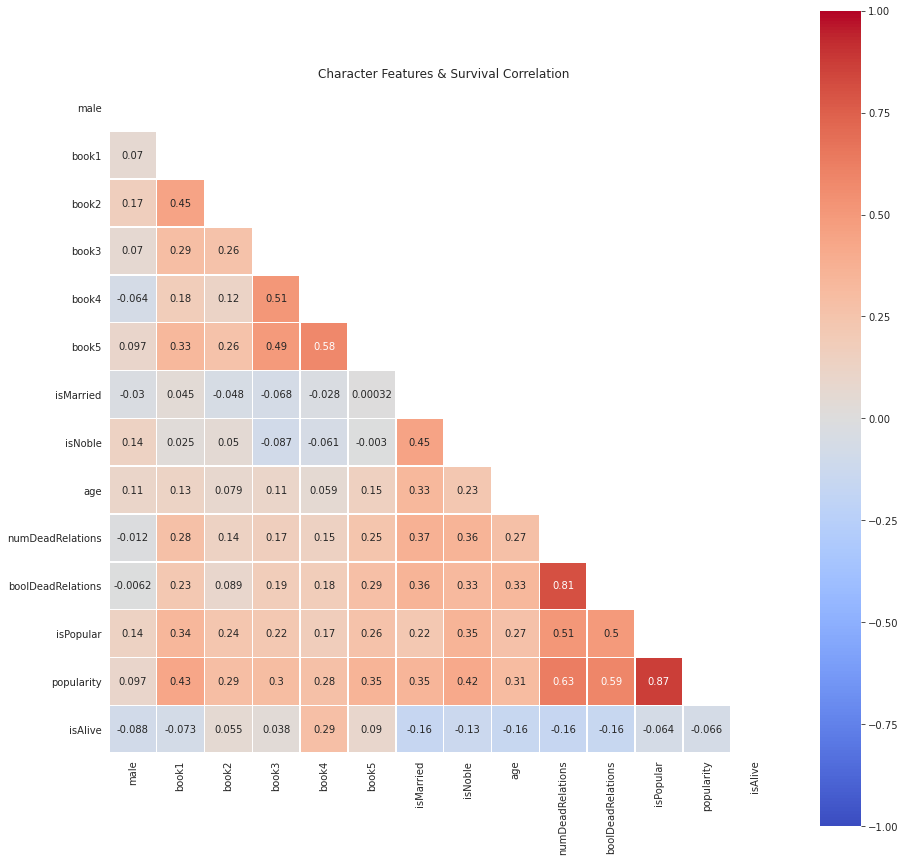

In [118]:
# Visualize correlations
plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, 
            mask = mask, 
            square=True, 
            annot=True,
            linewidths = .5, 
            cmap='coolwarm',
            vmin = -1, 
            vmax = 1)

plt.title("Character Features & Survival Correlation")
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Looking at the heatmap above, let's reflect on our initial questions. A strong correlation coefficent is greater than 0.8. A correlation under 0.5 is generally described as weak. There aren't any correlations: neither strong nor week in a positive or negative direction between a character's survival and any of the features in our dataframe. The largest correlation value for "isAlive" is whether the spouse is alive, which at 0.35 doesn't even meet the bar for a weak level of correlation. In the heatmap above, only the numeric columns were calculated, so it's possible there's a correlation between house and survival. The age variable is frequently missing, and may provide more signal if it's mapped to categories like "young", "middle-aged" and "elder" instead of exact ages.

### **CHECKING CLASS BALANCE**
Let's look at the balance of characters alive vs dead and the representation of each house and culture.  

In [119]:
df.isAlive.value_counts()

1    270
0    165
Name: isAlive, dtype: int64

The dataset isn't heavily skewed in one direction. The living represent 62% of the dataset, and the dead 38%. 

In [120]:
# What is the representation of each house in the data?
df.house.value_counts() / len(df)

Night's Watch    0.241379
 Stark           0.165517
 Targaryen       0.142529
 Lannister       0.112644
 Greyjoy         0.094253
 Tyrell          0.082759
 Martell         0.066667
 Arryn           0.036782
 Baratheon       0.029885
 Tully           0.027586
Name: house, dtype: float64

Out of 435 characters, Night's Watch represents 24% of the data with 2.8% being from the smallest house, Tully. A prediction is more likely to be accurate for houses with larger representation in the dataset vs houses with less representation because the model will have fewer examples to train on for that particular house. 

In [121]:
# How many characters per house?
df.groupby(['house']).count()

,name,male,culture,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
house,,,,,,,,,,,,,,,,
Arryn,16,16,4,16,16,16,16,16,16,16,16,16,16,16,16,16
Baratheon,13,13,1,13,13,13,13,13,13,13,13,13,13,13,13,13
Greyjoy,41,41,28,41,41,41,41,41,41,41,41,41,41,41,41,41
Lannister,49,49,10,49,49,49,49,49,49,49,49,49,49,49,49,49
Martell,29,29,18,29,29,29,29,29,29,29,29,29,29,29,29,29
Stark,72,72,60,72,72,72,72,72,72,72,72,72,72,72,72,72
Targaryen,62,62,42,62,62,62,62,62,62,62,62,62,62,62,62,62
Tully,12,12,6,12,12,12,12,12,12,12,12,12,12,12,12,12
Tyrell,36,36,6,36,36,36,36,36,36,36,36,36,36,36,36,36


In [122]:
# Group by house, survival
df.groupby(['house', 'isAlive']).count()

name  male  ...  isPopular  popularity
house         isAlive              ...                       
 Arryn        0           6     6  ...          6           6
              1          10    10  ...         10          10
 Baratheon    0           6     6  ...          6           6
              1           7     7  ...          7           7
 Greyjoy      0          14    14  ...         14          14
              1          27    27  ...         27          27
 Lannister    0          18    18  ...         18          18
              1          31    31  ...         31          31
 Martell      0           4     4  ...          4           4
              1          25    25  ...         25          25
 Stark        0          22    22  ...         22          22
              1          50    50  ...         50          50
 Targaryen    0          41    41  ...         41          41
              1          21    21  ...         21          21
 Tully        0           7     7  ...          7           7
              1           5     5  ...          5           5
 Tyrell       0           2     2  ...          2           2
              1          34    34  ...         34          34
Night's Watch 0          45    45  ...         45          45
              1          60    60  ...         60          60

[20 rows x 15 columns]

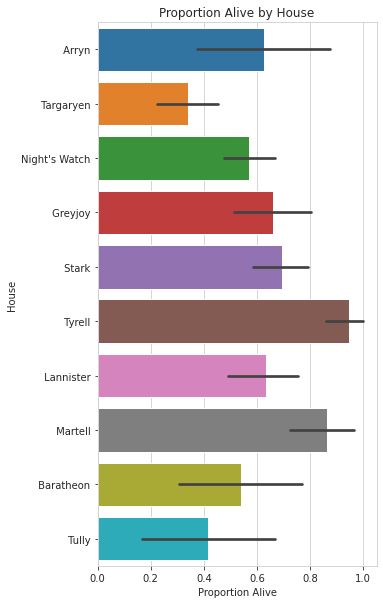

In [123]:
# Plot proportion alive by house
sns.barplot(x='isAlive', y='house', data=df)
fig = plt.gcf()
fig.set_size_inches(5, 10)
plt.xlabel("Proportion Alive")
plt.ylabel("House")
plt.title("Proportion Alive by House")
plt.savefig("proportion_alive_by_house.png", format='png',dpi=150)

House Tyrell has the largest portion alive, while Targaryens have the least portion of their house alive. This matches up with the history of Westeros which inclues a major war between two Targaryens that resulted in the destruction of most of house Targaryen and nearly all their dragons.

In [124]:
# Get unique culture values regardless 
df['culture'].str.title().unique()

array([nan, 'Valyrian', 'Ironborn', 'Northmen', 'Reach', 'Lhazarene',
       'Westermen', 'Westerman', 'Summer Isles', 'Dothraki', 'Westeros',
       'Rivermen', 'Vale', 'Sistermen', 'Wildling', 'Dorne', 'Dornishmen',
       'Dornish', 'Tyroshi', 'Westerlands', 'Naathi', 'Rhoynar',
       'Free Folk', 'Ironmen', 'Norvos', 'Meereenese', 'First Men',
       'Lysene', 'Pentoshi', 'Valemen', 'Stormlands', 'Braavosi',
       'Wildlings', 'The Reach'], dtype=object)

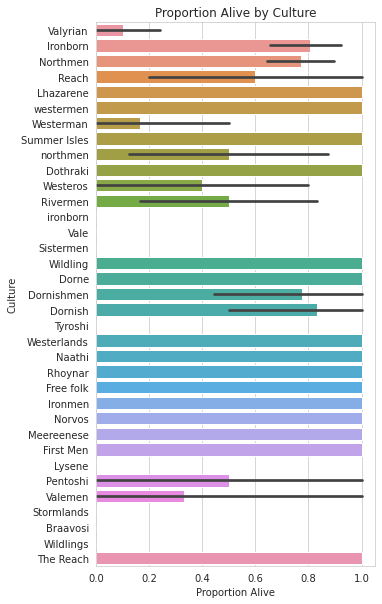

In [125]:
# Plot proportion alive by culture
sns.set_style('whitegrid')
culture = list(df['culture'].str.title().unique())
ax = sns.barplot(x='isAlive', y='culture', data=df)
fig = plt.gcf()
fig.set_size_inches(5, 10)
plt.xlabel("Proportion Alive")
plt.ylabel("Culture")
plt.title("Proportion Alive by Culture")
plt.savefig("proportion_alive_by_culture.png", format='png',dpi=150)

This doesn't seem right. The First Men are the original human inhabitants of Westeros, so it's unlikely they are alive. Let's look at the counts behind these percentages.

In [126]:
df.loc[df['culture'] == 'First Men'][['name', 'isAlive']]

,name,isAlive
S.No,,
1665,Bran the Builder,1


In [127]:
df.culture.value_counts()

Northmen        48
Valyrian        29
Ironborn        26
Dornishmen       9
northmen         8
Dornish          6
Westerman        6
Rivermen         6
Dothraki         5
Reach            5
Westeros         5
Valemen          3
westermen        2
Westerlands      2
Pentoshi         2
Ironmen          2
Wildlings        1
Dorne            1
Meereenese       1
Lysene           1
Braavosi         1
Tyroshi          1
Vale             1
Sistermen        1
Wildling         1
Stormlands       1
First Men        1
Lhazarene        1
ironborn         1
Summer Isles     1
The Reach        1
Norvos           1
Naathi           1
Rhoynar          1
Free folk        1
Name: culture, dtype: int64

In [128]:
df.culture.nunique()

35

Compared with the house value where we have no null values, the culture value is not likely to be as helpful to predict death. There are 35 unique cultures, and the distribution is sparsely spread across the remaining 32 cultures after the top 3 cultures. There are 19 cultures with just a single person in the culture.

In [129]:
df.head()

,name,male,culture,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,
4,Aemma Arryn,0,NaN,Arryn,0,0,0,0,0,1,1,1,0,0,0,0.183946,0
7,Valarr Targaryen,1,Valyrian,Targaryen,0,0,0,0,0,1,1,2,0,0,1,0.431438,0
11,Will,1,NaN,Night's Watch,1,1,0,0,0,0,0,1,0,0,0,0.163880,0
28,Wulfe,1,Ironborn,Greyjoy,0,0,0,1,1,0,0,1,0,0,0,0.023411,1
30,Wyl (guard),0,Northmen,Stark,1,0,0,0,0,0,0,1,0,0,0,0.026756,0


##**PREPARE DATA FOR MODELING**
The next steps to prepare the data for ML algorithms are drop columns: culture, name, numDeadRelations. Convert categorical house values to numeric, and group age and popularity into buckets.

**Drop columns not useful for ML model**

In [130]:
df.drop(['culture', 'name', 'numDeadRelations'], axis=1)

,male,house,book1,book2,book3,book4,book5,isMarried,isNoble,age,boolDeadRelations,isPopular,popularity,isAlive
S.No,,,,,,,,,,,,,,
4,0,Arryn,0,0,0,0,0,1,1,1,0,0,0.183946,0
7,1,Targaryen,0,0,0,0,0,1,1,2,0,1,0.431438,0
11,1,Night's Watch,1,1,0,0,0,0,0,1,0,0,0.163880,0
28,1,Greyjoy,0,0,0,1,1,0,0,1,0,0,0.023411,1
30,0,Stark,1,0,0,0,0,0,0,1,0,0,0.026756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1,Tyrell,1,1,1,1,1,0,1,1,1,1,0.665552,1
1929,0,Martell,0,0,0,1,1,0,1,1,0,0,0.070234,1
1932,1,Targaryen,0,0,0,0,1,1,0,1,0,0,0.050167,1


**Turn House Into Numeric Values**

In [ ]:
house = {"Stark": 1, "Arryn": 2,"Baratheon": 3, "Tully": 4, "Greyjoy": 5, 
        "Lannister": 6, "Tyrell": 7, "Martell": 8, "Targaryen": 9, 
        "Night's Watch": 10}

df['house'] = df['house'].map(house)
df['house'] = df['house'].astype(int)

In [ ]:
df.info()

In [ ]:
df['age'].isnull().sum()

**TODO: Group ages**

**TODO: Group popularity**